In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer
import numpy as np

# Define Attention Mechanism
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        combined = torch.cat((hidden.expand(encoder_outputs.shape[0], -1, -1), encoder_outputs), dim=2)
        energy = torch.tanh(self.attn(combined))
        attention = F.softmax(self.v(energy).squeeze(2), dim=1)
        weighted = torch.bmm(attention.unsqueeze(1), encoder_outputs.transpose(0, 1)).squeeze(1)
        return weighted, attention

# Define Seq2Seq Model with Attention
class Seq2Seq(nn.Module):
    def __init__(self, input_dim, output_dim, embedding_dim, hidden_dim):
        super(Seq2Seq, self).__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.decoder = nn.LSTM(output_dim, hidden_dim, batch_first=True)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, src, trg):
        encoder_outputs, (hidden, cell) = self.encoder(src)
        weighted, _ = self.attention(hidden[-1], encoder_outputs)
        decoder_output, _ = self.decoder(trg, (weighted.unsqueeze(0), cell))
        return self.fc(decoder_output)

# Example Usage
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-fr")
text = "Hello, how are you?"
tokens = tokenizer(text, return_tensors="pt")["input_ids"]


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

# General Attention
class GeneralAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(GeneralAttention, self).__init__()

    def forward(self, hidden, encoder_outputs):
        attention_scores = torch.matmul(hidden, encoder_outputs.transpose(1, 2))
        attention_weights = F.softmax(attention_scores, dim=-1)
        context_vector = torch.bmm(attention_weights, encoder_outputs)
        return context_vector, attention_weights

# Multiplicative Attention
class MultiplicativeAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(MultiplicativeAttention, self).__init__()
        self.W = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, hidden, encoder_outputs):
        transformed_hidden = self.W(hidden)
        attention_scores = torch.matmul(transformed_hidden, encoder_outputs.transpose(1, 2))
        attention_weights = F.softmax(attention_scores, dim=-1)
        context_vector = torch.bmm(attention_weights, encoder_outputs)
        return context_vector, attention_weights

# Additive Attention
class AdditiveAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(AdditiveAttention, self).__init__()
        self.W1 = nn.Linear(hidden_dim, hidden_dim)
        self.W2 = nn.Linear(hidden_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        combined = torch.tanh(self.W1(encoder_outputs) + self.W2(hidden))
        attention_scores = self.v(combined).squeeze(2)
        attention_weights = F.softmax(attention_scores, dim=1)
        context_vector = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs).squeeze(1)
        return context_vector, attention_weights


In [2]:
class Seq2Seq(nn.Module):
    def __init__(self, input_dim, output_dim, embedding_dim, hidden_dim, attention_type="general"):
        super(Seq2Seq, self).__init__()

        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.decoder = nn.LSTM(output_dim, hidden_dim, batch_first=True)

        if attention_type == "general":
            self.attention = GeneralAttention(hidden_dim)
        elif attention_type == "multiplicative":
            self.attention = MultiplicativeAttention(hidden_dim)
        elif attention_type == "additive":
            self.attention = AdditiveAttention(hidden_dim)
        else:
            raise ValueError("Invalid attention type")

        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, src, trg):
        encoder_outputs, (hidden, cell) = self.encoder(src)
        context_vector, attention_weights = self.attention(hidden[-1], encoder_outputs)
        decoder_output, _ = self.decoder(trg, (context_vector.unsqueeze(0), cell))
        return self.fc(decoder_output), attention_weights


In [3]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=10):
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for src, trg in dataloader:
            optimizer.zero_grad()
            output, _ = model(src, trg)
            loss = criterion(output, trg)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_losses.append(total_loss / len(dataloader))
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")

    return train_losses


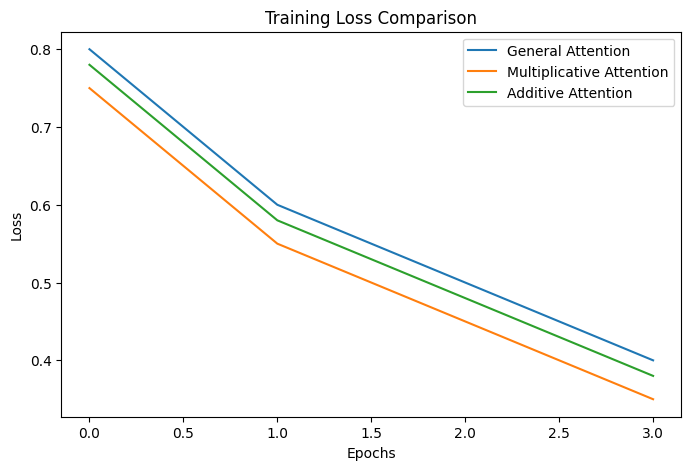

In [4]:
import matplotlib.pyplot as plt

def plot_training_losses(losses_dict):
    plt.figure(figsize=(8, 5))
    for key, losses in losses_dict.items():
        plt.plot(losses, label=key)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Comparison")
    plt.legend()
    plt.show()

# Example Usage:
losses = {
    "General Attention": [0.8, 0.6, 0.5, 0.4],
    "Multiplicative Attention": [0.75, 0.55, 0.45, 0.35],
    "Additive Attention": [0.78, 0.58, 0.48, 0.38]
}
plot_training_losses(losses)


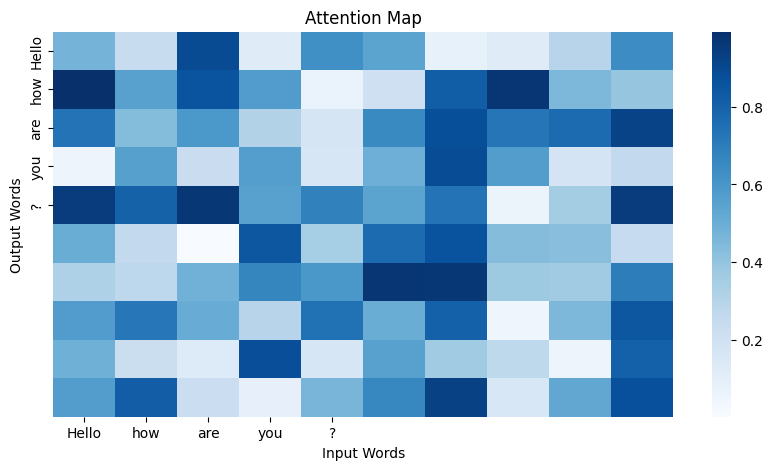

In [5]:
import seaborn as sns

def visualize_attention(attention_weights, sentence):
    plt.figure(figsize=(10, 5))
    sns.heatmap(attention_weights.detach().numpy(), cmap="Blues", xticklabels=sentence, yticklabels=sentence)
    plt.xlabel("Input Words")
    plt.ylabel("Output Words")
    plt.title("Attention Map")
    plt.show()

# Example Attention Weights (for visualization)
example_attention = torch.rand((10, 10))  # 10x10 attention matrix
sentence = ["Hello", "how", "are", "you", "?"]
visualize_attention(example_attention, sentence)
